# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


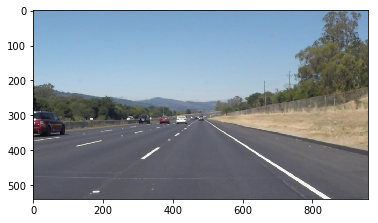

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Convert image to grayscale
    """
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)


def filterImage(img):
    """2. Apply Sobel Detector on the x axis.
    Sobel operator is Gaussian Smoothing plus a differentiation operator.
    Typically sobel detector is done for x and y axis, but in our case since
    the lanes are vertical we can just apply the filter in x axis and therefore
    removing most noise in the y axis.
    Arguments as follows
    1. source image
    2. size of out, here chosen unsigned 8bit/pixel (CV_8U)
    3. xorder ;choose 1 for doing a sobel operator in x axis
    4. yorder ;choose 0 for not doing a sobel operator in y axis
    5. kernel size ;Still experimenting with this parameter,
                    size of 1 gives the lowest noise, 
                    3X3 also works almost well
    """
    sobelx = cv2.Sobel(img, cv2.CV_8U, 1, 0, ksize=1)
    return sobelx
    
def canny(img, low_threshold=30, high_threshold=100):
    """Applies the Canny transform
    """
    return cv2.Canny(img, low_threshold, high_threshold)

def generateVertices(challenge=False):
    """Verices for polygon, used in masking.
    """
    if challenge:
        baseGround = 680
        baseTop = 450
        rootGround = 250
        rootTop = 585
        groundDist = 910
        topDist = 155
    else:
        baseGround = 540
        baseTop = 330
        rootGround = 105
        rootTop = 419
        groundDist = 830
        topDist = 140

    vertices = np.array([[(rootGround, baseGround),
                        (rootTop, baseTop),
                        (rootTop + topDist, baseTop),
                        (rootGround + groundDist, baseGround)]],
                        dtype=np.int32)

    return vertices

def region_of_interest(img, challenge=False):
    """
    Applies an image mask.
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    mask = np.zeros_like(img)
    vertices = generateVertices(challenge)
    cv2.fillPoly(mask, vertices, 255)
    masked_edges = cv2.bitwise_and(img, mask)
    return masked_edges

def generateHoughLines(image):
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 50    # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 15 #minimum number of pixels making up a line
    max_line_gap = 30    # maximum gap in pixels between connectable line segments
    
    lines = cv2.HoughLinesP(image, rho, theta, threshold, np.array([]),
                                min_line_length, max_line_gap)
    return lines

def drawHoughLines(lines, image):
    lane_image =  np.copy(image)*0
    if lines is None:
        pass
    else:
        for line in lines:
            for x1, y1, x2, y2 in line:
                cv2.line(lane_image, (x1, y1), (x2, y2), (255, 0, 0), 10)
    return lane_image
    
def avg_lines (lines):
    """HoughTransform in the previous step generates multiple lines in the visible
    region. This function calculates the slope of all identified lines and segregates
    them, so each line either beongs to be part of left lane or right lane.
    Then these two sets are averaged to two distinct lanes.
    """
    left_line = []
    right_line = []
    line = []

    if lines is None:
        pass
    else:
        for line in lines:
            for  x1, y1, x2, y2 in line:
                if x1==x2:
                    continue # omit vertical lines, We dont want division be zeros!
                line_slope = (y2-y1)/(x2-x1) # slope of line
                line_intercept = y1 - line_slope*x1 # intercept of line
                line_length = np.sqrt((y2-y1)**2 + (x2-x1)**2) # weight or line length

                if line_slope > 0:
                    # since image coordinates are reversed a positive slope denotes
                    # right lane
                    right_line.append([line_slope,
                                        line_intercept,
                                        line_length])
                elif line_slope < 0:
                    left_line.append([line_slope,
                                        line_intercept,
                                        line_length])

    right_line = np.array(right_line) 
    left_line = np.array(left_line)
    
    # (length * (slope,intercept)) / sum of all lengths
    left_lane = np.dot(left_line[:,2], left_line[:,:2]) / np.sum(left_line[:,2]) \
                                if len(left_line) >0 else None
        
    right_lane = np.dot(right_line[:,2], right_line[:,:2]) / np.sum(right_line[:,2]) \
                            if len(right_line) >0 else None
    
    return left_lane, right_lane

def draw_lane(left_lane, right_lane, image, y1=540, y2=330):
    """Draw the two lines (left and right lane) found from the average function
    on a blank image.
    """
    lane_image =  np.copy(image)*0 # generate blank image.
#     y1 = 540 #start line from bottom of the image
#     y2 = 330 #start line from top of the image
    
    if left_lane is None:
        pass
    else:
        LX1 = int((y1 - left_lane[1]) / (left_lane[0]+0.01))
        LX2 = int((y2 - left_lane[1]) / (left_lane[0]+0.01))
        LY1 = int(y1)
        LY2 = int(y2)
        cv2.line(lane_image, (LX1, LY1), (LX2, LY2), (255, 0, 0), 10)
    
    if right_lane is None:
        pass
    else:
        RX1 = int((y1 - right_lane[1]) / (right_lane[0]-0.01))
        RX2 = int((y2 - right_lane[1]) / (right_lane[0]-0.01))
        RY1 = int(y1)
        RY2 = int(y2)
        cv2.line(lane_image, (RX1, RY1), (RX2, RY2), (255, 0, 0), 10)
    
    return lane_image
    
def weighted_img(laneImage, image, α=0.8, β=1., λ=0.):
    return cv2.addWeighted(image, α, laneImage, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import glob
image_addr = glob.glob('test_images/*')

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [5]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

In [6]:
images = []
#Read all images from directory
for item in image_addr:
    img = mpimg.imread(item)
    images.append(img)

In [7]:
seg_image = []
out_image = []
for image in images:
    gray_image = grayscale(image)
    filter_image = filterImage(gray_image)

    canny_image = canny(filter_image)
    mask_image = region_of_interest(canny_image)

    hough_lines = generateHoughLines(mask_image)
    
    hough_image = drawHoughLines(hough_lines, image) # to show segmented lane lines
    seg_image.append(weighted_img(hough_image, image)) # not necessary in pipeline
    
    left_lane_lines, right_lane_lines = avg_lines(hough_lines)

    lane_image = draw_lane(left_lane_lines, right_lane_lines, image)
    combo_image = weighted_img(lane_image, image)
    out_image.append(combo_image)
    

### Images with segmented lane line

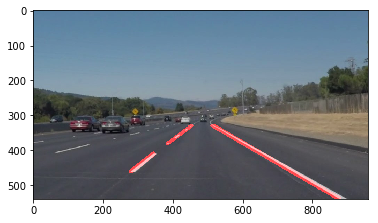

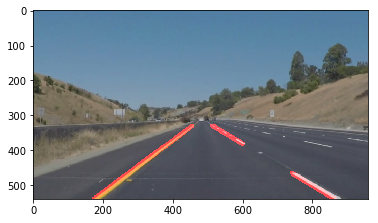

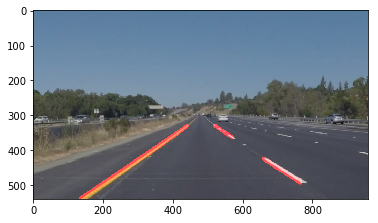

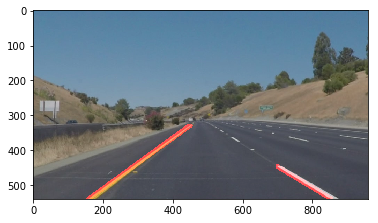

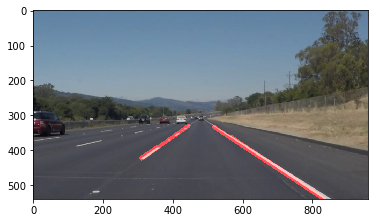

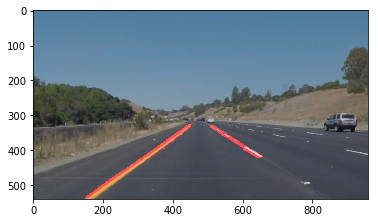

In [8]:
## Segmented images
for simg in seg_image:
    plt.imshow(simg)
    plt.show()

In [9]:
### Images with lane lines averaged out

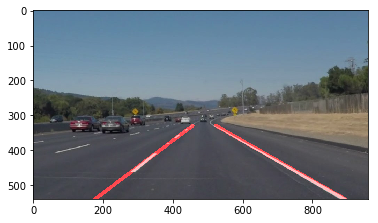

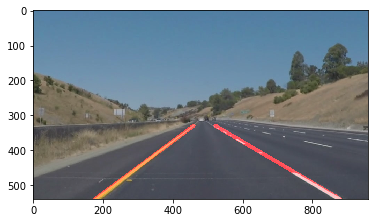

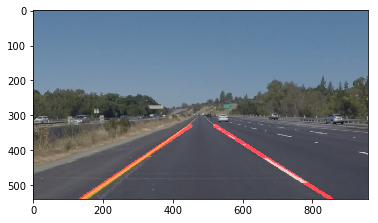

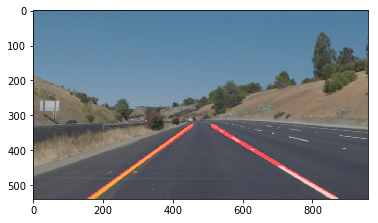

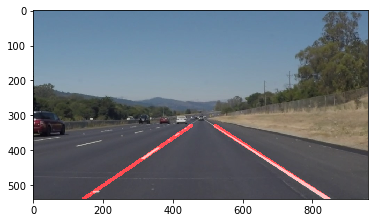

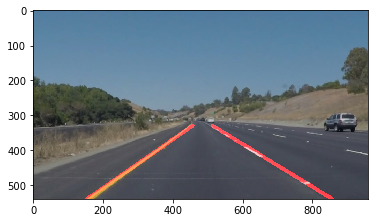

In [10]:
## averaged out, continuous lane lines
for oimg in out_image:
    plt.imshow(oimg)
    plt.show()

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [11]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

### The following pipeline produces segmented lane lines

In [15]:
def process_image_segmented(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    gray_image = grayscale(image)
    filter_image = filterImage(gray_image)

    canny_image = canny(filter_image)
    mask_image = region_of_interest(canny_image)

    hough_lines = generateHoughLines(mask_image)

    hough_image = drawHoughLines(hough_lines, image)
    result = weighted_img(hough_image, image)
    return result


Let's try the one with the solid white lane on the right first ...

In [16]:
white_output = 'test_videos_output/solidWhiteRight.mp4'

clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image_segmented) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:05<00:00, 36.58it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 32.2 s, sys: 168 ms, total: 32.4 s
Wall time: 6.41 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [18]:
HTML("""
<video width="800" height="450" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

## updated pipeline, no more segmentation.

In [19]:
def process_image(image):
    gray_image = grayscale(image)
    filter_image = filterImage(gray_image)

    canny_image = canny(filter_image)
    mask_image = region_of_interest(canny_image)

    hough_lines = generateHoughLines(mask_image)

    left_lane_lines, right_lane_lines = avg_lines(hough_lines)
    lane_image = draw_lane(left_lane_lines, right_lane_lines, image)
    result = weighted_img(lane_image, image)
    return result


In [20]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'

clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:18<00:00, 35.92it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 1min 40s, sys: 508 ms, total: 1min 41s
Wall time: 19.3 s


In [21]:
HTML("""
<video width="800" height="450" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

## Modified pipline for challenge video
Observations (_in comparison to previous videos_): 
- car hood visible
- resolution 1280 X 720
- more shadowed regions
<br></br>
<br></br>
**Solution**
- An additional layer of filter is added
    - Its a bilateral filter. They maintain edges while smoothing out shadowed regions. 
    This is done using the cv2 method:
    `cv2.bilateralFilter(src, d, sigmaColor, sigmaSpace)`
- Vertices of the masking trapezoid has been changed to fit the resolution and camera position.
<br></br>
<br></br>
_Note : It is far from perfect, more tweaking is required. Maybe some operations in the color space to eliminate jitters from when the car is moving to a brighter spot from a shadowed region._

In [24]:
def process_image_challenge(image):
    blur = cv2.bilateralFilter(image, d=5, sigmaColor=75, sigmaSpace=75)
    gray_image = grayscale(blur)
    filter_image = filterImage(gray_image)
    canny_image = canny(filter_image)
    mask_image = region_of_interest(canny_image, challenge=True)
    hough_lines = generateHoughLines(mask_image)
    
    left_lane_lines, right_lane_lines = avg_lines(hough_lines)
    lane_image = draw_lane(left_lane_lines, right_lane_lines, image, 
                           680, 450)
    result = weighted_img(lane_image, image)
    
    return result

In [25]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,2)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image_challenge)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:14<00:00, 17.35it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 1min 15s, sys: 372 ms, total: 1min 15s
Wall time: 15.1 s


In [30]:
HTML("""
<video width="800" height="450"controls>
  <source src="{0}">
</video>
""".format(challenge_output))